In [2]:
!pip install fastbook

     |████████████████████████████████| 727kB 4.3MB/s 
     |████████████████████████████████| 1.2MB 31.5MB/s 
     |████████████████████████████████| 204kB 35.5MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [4]:
#hide
# import ALL of fastbooks libraries & import ALL fastai's vision widgets
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision.all import *

In [4]:
!pip install DuckDuckGoImages

     |████████████████████████████████| 61kB 2.9MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [1]:
# import the DuckDuckGo image scraper
import DuckDuckGoImages as ddg

In [2]:
from pathlib import Path

In [19]:
# create a filder for overall search results
# search/download each subcategory and place them in their corresponding subfolder
bear_types = 'grizzly','black','teddy'
path = Path('bears')
for o in bear_types:
    ims = ddg.download(f'{o} bear', folder=f'./bears/{o}', max_urls=200)

In [20]:
# get all the image file paths from the download directory
fns = get_image_files(Path()/"bears")
# fns

In [23]:
# test verify the images can be opened
failed = verify_images(fns)
failed

(#29) [Path('bears/teddy/f48bfb56cca646ebb9361b9c8ae4e8bb.jpg'),Path('bears/teddy/83f5b0942f5c47c9879576e1eac77fff.jpg'),Path('bears/teddy/c52fbdb0ac9f45aea5187619b6655165.jpg'),Path('bears/teddy/11932f693fe6456f865609eeab4960d0.jpg'),Path('bears/teddy/42c6a8e4f31b41108ad238ce36957442.jpg'),Path('bears/teddy/ca318a77b7c14062bbf166868cfbcc1c.jpg'),Path('bears/teddy/db9bc67c99fb4365ad037a94dd0e1e60.jpg'),Path('bears/teddy/9c86baedf8bd49538b45ffe097859c51.jpg'),Path('bears/teddy/c0448e6a8f67467daf83dc9104017fbe.jpg'),Path('bears/teddy/ea9ab9281d2843de878f1e096ac4a28c.jpg')...]

In [24]:
# delete images that failed to open
failed.map(Path.unlink);

FileNotFoundError: ignored

## From Data to DataLoaders

In [25]:
# Create/Specify a DataBlock by passing in:
    # types of Data & Labels
    # the function to get items
    # function so split out the validation set
    # functions to get y labels
    # an item_tfms
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [26]:
# create some data loaders from the DataBlock & Location
dls = bears.dataloaders(path)

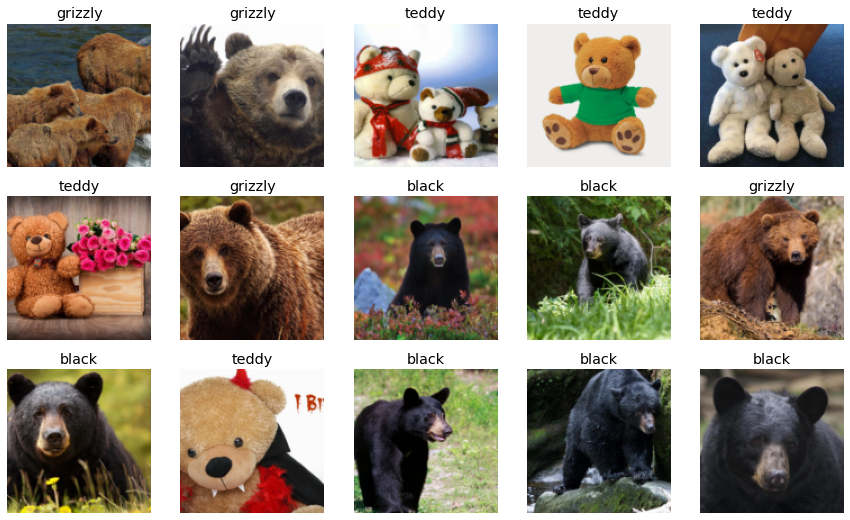

In [13]:
# show a few datapoints from teh data loader:
    # validation set
    # training set?
dls.valid.show_batch(max_n=15, nrows=3)

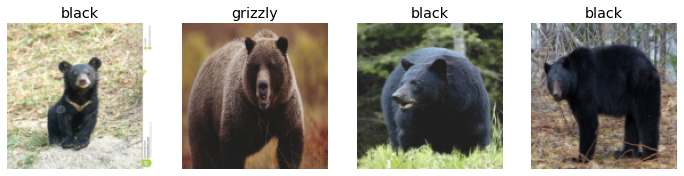

In [ ]:
# recreate the previous Datablock that uses a Squish style resizing method
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

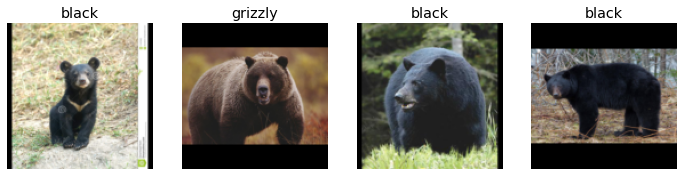

In [ ]:
# recreate the previous Datablock that uses a Pad style resizing method
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

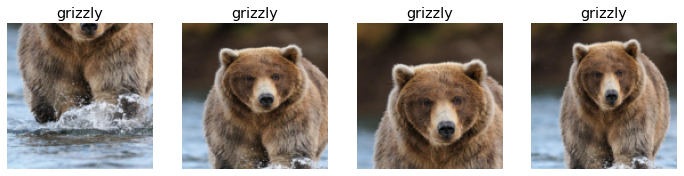

In [ ]:
# recreate the previous Datablock that uses a resizing method
# a method that randomly selects ~30% of the image & zooms in on it
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

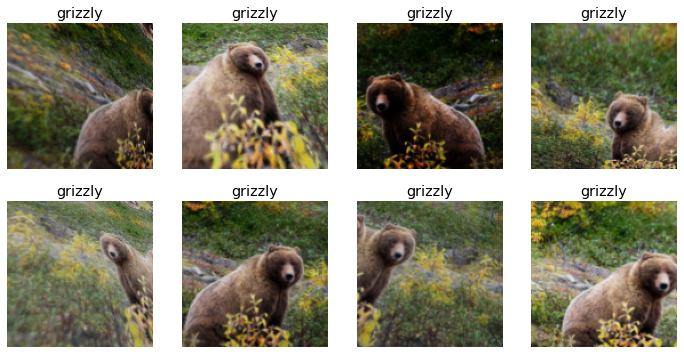

In [14]:
# recreate the previous Datablock that 
# uses the default item size transform
# uses multiple different kinds batch transforms resizing method
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [29]:
# recreate the previous Datablock & Dataloader that
# zooms in on a particular part of the image
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [30]:
# create a learning with the dataloaders, architecture, & ?optimizer?
# fine_tune the learner
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

In [ ]:
# export model architecture & parameters of model
learn.export()

In [ ]:
# create a inference learner from an exported model
learn_inf = load_learner(path/'export.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'bears/export.pkl'

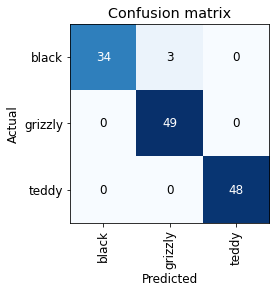

In [31]:
# Create a interpreter & plot the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

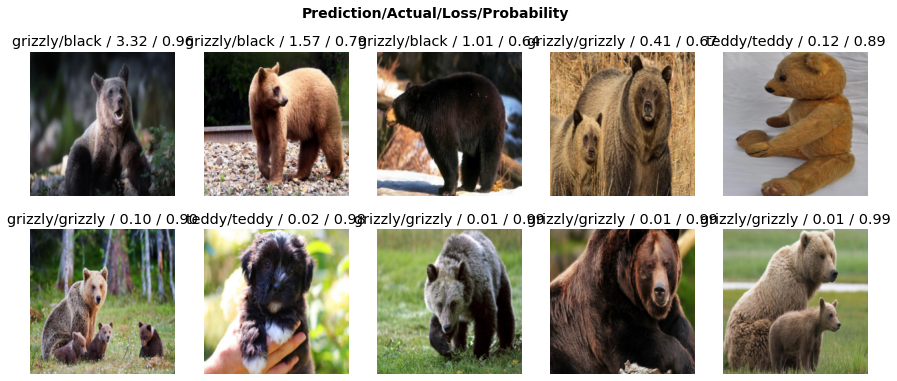

In [32]:
# show data points with worst Cost Func losses
# show worst wrong predictions & low confidence predictions
interp.plot_top_losses(10, nrows=2)

In [33]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [34]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [35]:
# export model architecture & parameters of model
learn.export()

In [ ]:
# show exported model in working directory
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
# create a inference learner from an exported model
learn_inf = load_learner(Path()/'export.pkl')

In [ ]:
# do an example prediction on the inferenced learner
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([5.0657e-04, 9.9949e-01, 4.2295e-08]))

In [ ]:
# show the categories in the learners data loaders
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

### Creating a Notebook App from the Model

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9999')

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila 

### Deploying your app

## How to Avoid Disaster

### Unforeseen Consequences and Feedback Loops

## Get Writing!

## Questionnaire

1. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.
1. Where do text models currently have a major deficiency?
1. What are possible negative societal implications of text generation models?
1. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?
1. What kind of tabular data is deep learning particularly good at?
1. What's a key downside of directly using a deep learning model for recommendation systems?
1. What are the steps of the Drivetrain Approach?
1. How do the steps of the Drivetrain Approach map to a recommendation system?
1. Create an image recognition model using data you curate, and deploy it on the web.
1. What is `DataLoaders`?
1. What four things do we need to tell fastai to create `DataLoaders`?
1. What does the `splitter` parameter to `DataBlock` do?
1. How do we ensure a random split always gives the same validation set?
1. What letters are often used to signify the independent and dependent variables?
1. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?
1. What is data augmentation? Why is it needed?
1. What is the difference between `item_tfms` and `batch_tfms`?
1. What is a confusion matrix?
1. What does `export` save?
1. What is it called when we use a model for getting predictions, instead of training?
1. What are IPython widgets?
1. When might you want to use CPU for deployment? When might GPU be better?
1. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?
1. What are three examples of problems that could occur when rolling out a bear warning system in practice?
1. What is "out-of-domain data"?
1. What is "domain shift"?
1. What are the three steps in the deployment process?

### Further Research

1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?
1. For a project you're interested in applying deep learning to, consider the thought experiment "What would happen if it went really, really well?"
1. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.